# Error estimation
**Note: first run of this cell takes a while**

In [27]:

%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../../src')
import util, config, plots
import ipynbname
import pandas as pd
import numpy as np
import json
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
import plotly.express as px
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Simulation of standard deviation w.r.t modification rate

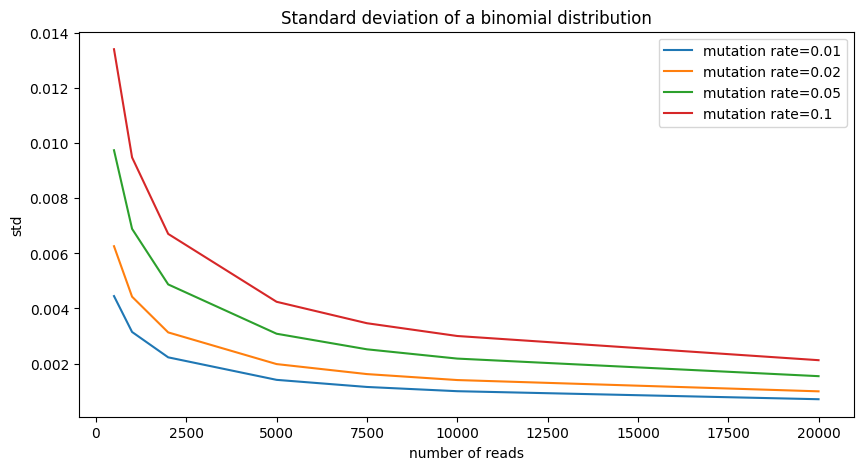

In [28]:
# plot the satndard deviation of a binomial distribution with n=[500, 1000, 2000, 5000, 7500, 10000, 20000] and p=[0.01, 0.02, 0.05, 0.1]
n = np.array([500, 1000, 2000, 5000, 7500, 10000, 20000])
p = np.array([0.01, 0.02, 0.05, 0.1])
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for p_ in p:
    ax.plot(n, np.sqrt(p_*(1-p_)/n), label=f'mutation rate={p_}')
ax.set(xlabel='number of reads', ylabel='std', title='Standard deviation of a binomial distribution')
ax.legend()
plt.show()
    

## Introduction

The bootstrap always fits a binomial distribution, independent of the underlying distribution. 

In [29]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Full dataset stats
N, D = 10000, 1000
data = np.concatenate(( (np.random.rand(N, D//2) < 0.02).astype(int), (np.random.rand(N, D//2) < 0.03).astype(int) ), axis=1)
muts_count = np.sum(data, axis=0)


# Stats on one column of data
data_col = data[:, np.random.randint(0, D-1)]

bootstrap_data = np.random.choice(data_col, size=(N, D), replace=True)

muts_count_bs = np.sum(bootstrap_data, axis=0)

# Make a Plotly subplot with the histogram of muts_count on the first row and the bootstrapping on the second row
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.02)

fig.add_trace(go.Histogram(x=muts_count, histnorm='probability density', name='Original dataset' ), col=1, row=1)

fig.add_trace(go.Histogram(x=muts_count_bs, histnorm='probability density', name='bootstrap data'), col=1, row=2)

# Draw a binomial distribution on top of the histogram, with n=1000 and p estimated from the data
from scipy.stats import binom
x = np.arange(min(muts_count_bs), max(muts_count_bs)).astype(int)
fig.add_trace(go.Scatter(x=x, y=binom.pmf(x, len(data_col), np.count_nonzero(data_col)/len(data_col)), mode='lines', name='binomial'), col=1, row=2)

## Generate fake dataset

/var/folders/00/r1kkxj7d0k344frrqtzrc5000000gn/T/ipykernel_55613/1704580288.py:17: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.



Text(0.5, 1.0, 'Quality assessment of the dataset: Observed vs True Frequency')

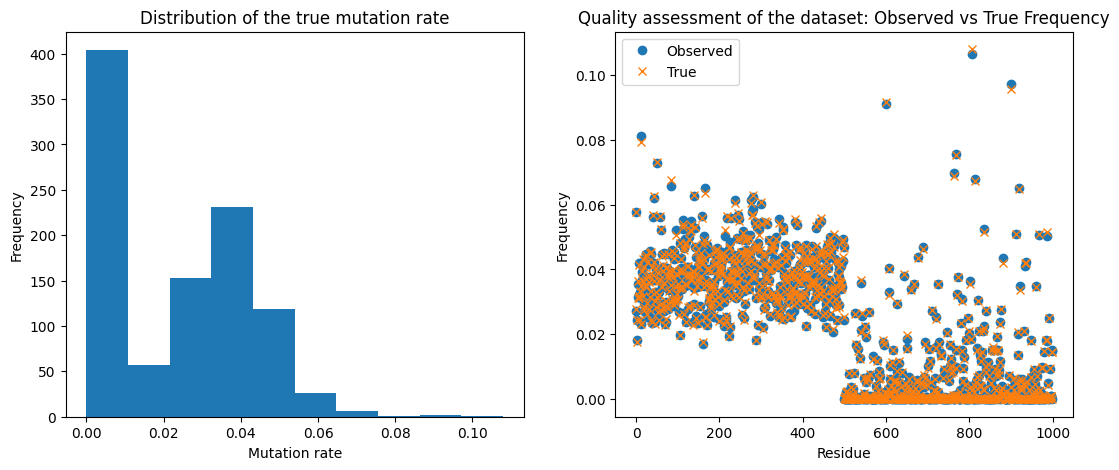

In [30]:
r = 1000 # number of residues
N = 100000 # number of reads

def generate_dataset(N, r):
    assert r % 2 == 0
    true_mutation_rate = np.concatenate([np.random.beta(20, 500, r//2) , np.random.beta(0.2, 30, r//2)])
    true_mutation_rate[true_mutation_rate < 0] = 0.001
    data = np.where(true_mutation_rate > np.random.rand(N, len(true_mutation_rate)), 1, 0) 
    return data, true_mutation_rate
    
def generate_sample(data, size_sample):
    return data[np.random.randint(0, N, size_sample)]

data, true_mutation_rate = generate_dataset(N, r)

plt.subplots(figsize=(13, 5))
plt.subplot(1, 2, 1)
plt.hist(true_mutation_rate, bins=10)
plt.title('Distribution of the true mutation rate')
plt.xlabel('Mutation rate')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.plot(data.sum(axis=0)/N, 'o')
plt.plot(true_mutation_rate, 'x')
plt.xlabel('Residue')
plt.ylabel('Frequency')
plt.legend(['Observed', 'True'])
plt.title('Quality assessment of the dataset: Observed vs True Frequency')

## Load real dataset

In [31]:
data = pd.read_orc('../../bv/01_1_s22_reads_3043.orc')

def process_data(data):
    data = data.to_numpy(dtype=np.byte).astype(float)
    data[data == 0] = 0
    data[data < 0] = 128
    data[data < 64] = 0
    data[data > 0] = 1
    return data

### Create a test sample


In [32]:
# sample is size_sample reads from data, randomly selected
size_sample = 2000
sample = generate_sample(data, size_sample)


KeyError: "None of [Int64Index([64152, 27401, 95041, 63457, 79169, 73087, 75265, 76312, 42840,\n            98939,\n            ...\n            30482, 22932, 34821, 73367, 49866, 46358, 91386, 26902, 16877,\n            57199],\n           dtype='int64', length=2000)] are in the [columns]"

Text(0.5, 0, 'Residue')

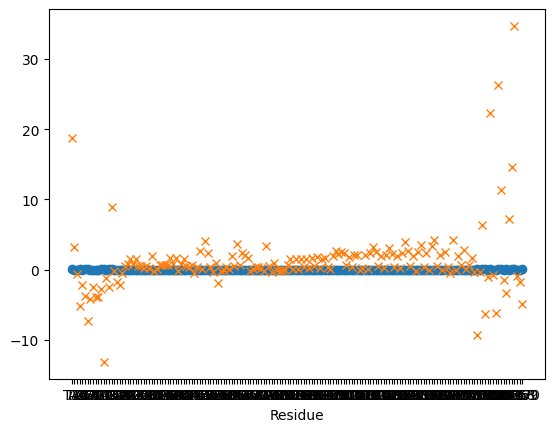

In [33]:
plt.plot(sample.sum(axis=0)/size_sample, 'o')
plt.plot(data.sum(axis=0)/data.shape[0], 'x')
plt.xlabel('Residue')

# Bootstrap vs binomial distribution


## Bootstrap
### Define bootstrap function

In [44]:
def bootstrap(sample, n=1000):
    """
    Bootstrap the sample
    """
    n, r = sample.shape
    res = np.zeros((n, r))
    for i in range(n):
        res[i] = sample[np.random.randint(0, n, n)].sum(axis=0)
    return res

### Predict confidence intervals with bootstrap

TypeError: can only concatenate str (not "int") to str

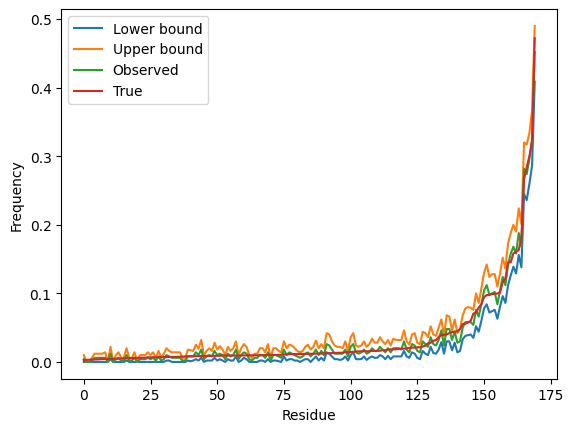

In [45]:
def predict_confidence_interval_bootstrap(sample, bootstrap_iterations=1000):
    bs = bootstrap(sample, n=bootstrap_iterations)
    lower_bound, upper_bound = np.percentile(bs, [2.5, 97.5], axis=0)/size_sample
    return lower_bound, upper_bound
    
def plot_confidence_interval_bootstrap(sample, data, size_sample, lower_bound, upper_bound):
    observed_freq = sample.sum(axis=0)/size_sample  
    real_freq = data.sum(axis=0)/data.shape[0]  
    ord = np.argsort(real_freq)
    observed_freq = observed_freq[ord]
    lower_bound = lower_bound[ord]
    upper_bound = upper_bound[ord]
    real_freq = real_freq[ord]
    
    plt.plot(lower_bound, label='Lower bound')
    plt.plot(upper_bound, label='Upper bound')
    plt.plot(observed_freq, label='Observed')
    plt.plot(real_freq, label='True')
    plt.legend()
    plt.xlabel('Residue')
    plt.ylabel('Frequency')
    plt.title('Bootstrap confidence interval, N = '+size_sample)
    
plot_confidence_interval_bootstrap(sample, data, size_sample, *predict_confidence_interval_bootstrap(sample))

## Binomial distribution

### Predict confidence intervals with binomial distribution 

TypeError: can only concatenate str (not "int") to str

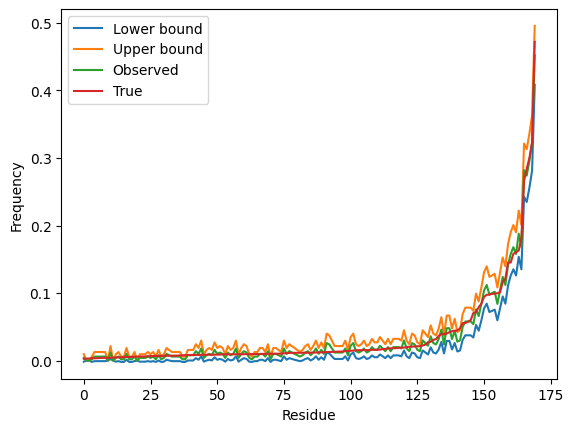

In [46]:

# start with the observed frequency, and the sample size, not the bitvector
observed_freq = sample.sum(axis=0)/size_sample

def predict_confidence_interval_binomial_distribution(observed_freq, size_sample):
    """
    Predict the confidence interval using the binomial distribution
    """
    lower_bound = observed_freq - 1.96*np.sqrt(observed_freq*(1-observed_freq)/size_sample)
    upper_bound = observed_freq + 1.96*np.sqrt(observed_freq*(1-observed_freq)/size_sample)
    return lower_bound, upper_bound
    
def plot_confidence_interval_binomial_distribution(observed_freq, data, size_sample, lower_bound, upper_bound):
    true_freq = data.sum(axis=0)/data.shape[0]
    ord = np.argsort(true_freq)
    observed_freq = observed_freq[ord]
    lower_bound = lower_bound[ord]
    upper_bound = upper_bound[ord]
    true_freq = true_freq[ord]
    plt.plot(lower_bound, label='Lower bound')
    plt.plot(upper_bound, label='Upper bound')
    plt.plot(observed_freq, label='Observed')
    plt.plot(true_freq, label='True')
    plt.legend()
    plt.xlabel('Residue')
    plt.ylabel('Frequency')
    plt.title('Binomial distribution confidence interval N = '+ size_sample)
    
plot_confidence_interval_binomial_distribution(observed_freq, data, size_sample, *predict_confidence_interval_binomial_distribution(observed_freq, size_sample))

## Compare bootstrap and binomial distribution

In [ ]:
observed_freq = sample.sum(axis=0)/size_sample
bootstrap_lower_bound, bootstrap_upper_bound = predict_confidence_interval_bootstrap(sample)
binomial_lower_bound, binomial_upper_bound = predict_confidence_interval_binomial_distribution(observed_freq, size_sample)

real_freq = data.sum(axis=0)/data.shape[0]
ord = np.argsort(real_freq)
real_freq = real_freq[ord]
observed_freq = observed_freq[ord]
bootstrap_lower_bound = bootstrap_lower_bound[ord]
bootstrap_upper_bound = bootstrap_upper_bound[ord]
binomial_lower_bound = binomial_lower_bound[ord]
binomial_upper_bound = binomial_upper_bound[ord]


plt.figure(figsize=(15, 5))
plt.plot(bootstrap_lower_bound, label='Bootstrap lower bound')
plt.plot(bootstrap_upper_bound, label='Bootstrap upper bound')
plt.plot(binomial_lower_bound, label='Binomial lower bound')
plt.plot(binomial_upper_bound, label='Binomial upper bound')
plt.plot(observed_freq, label='Observed')
plt.plot(real_freq, label='True')
plt.title('Comparison of the confidence intervals: Bootstrap vs Binomial, N = '+size_sample)
plt.xlabel('Residue')
plt.ylabel('Frequency')
plt.legend()

## Access bootstrap performance
Predict a confidence interval for a sub-sample of the data, and make sure that the confidence interval contains the true value.

In [ ]:
n_trials_per_dataset = 10
bootstrap_iterations = 1000
n_datasets = 10

bootstrap_failures = []
binomial_failures = []

sample_sizes = [2000]

for N in sample_sizes:
    
    print('N =', N)
    for f in os.listdir('../../bv'):
        
        data = process_data(pd.read_orc('../../bv/'+f))
        # generate a new dataset
        true_mutation_rate = data.sum(axis=0)/data.shape[0]
        

        fail_bootstrap, fail_binomial = [], []
        for _ in range(n_trials_per_dataset):
            
            # generate a new sample
            sample = data[np.random.randint(0, data.shape[0], size=N)]
            observed_freq = sample.sum(axis=0)/N
            
            # count failures bootstrap
            lb_bs, ub_bs = predict_confidence_interval_bootstrap(sample, bootstrap_iterations=bootstrap_iterations)
            fail_bootstrap.append(100*np.logical_or(ub_bs < true_mutation_rate, lb_bs > true_mutation_rate).sum()/data.shape[1])

            # count failures binomial
            lb_bin, ub_bin = predict_confidence_interval_binomial_distribution(observed_freq, N)
            fail_binomial.append(100*np.logical_or(ub_bs < true_mutation_rate, lb_bs > true_mutation_rate).sum()/data.shape[1])

        bootstrap_failures.append(fail_bootstrap)
        binomial_failures.append(fail_binomial)
        print(f'{f}: Binomial: {np.mean(binomial_failures[-1])}% failure rate')
        print(f'{f}: Bootstrap: {np.mean(bootstrap_failures[-1])}% failure rate')
        
    df = pd.DataFrame(
        {
            'Bootstrap': np.array(bootstrap_failures).flatten(), 
            'Binomial': np.array(binomial_failures).flatten(), 
            'Trial' : np.repeat(np.arange(n_trials_per_dataset),len(os.listdir('../../bv')))
        })
    df = pd.melt(df, id_vars=['Trial'], value_vars=['Bootstrap', 'Binomial'], var_name='Method', value_name='Failure rate (%)')

    fig = px.box(df, x='Trial', y='Failure rate (%)', color='Method', title='Failure rate of the confidence interval methods for data {} and sample size {}'.format(f, N))
    fig.show()

## Conclusion
The bootstrap method is equivalent the binomial distribution.

Boostrapping isn't a super reliable method to get confidence intervals on the test set (it's not a good idea to use the test set to estimate the performance of the model). However, it's a good method to get confidence intervals on the training set.

# Alternative methods performance assessment

### Read dataset


In [47]:
data = process_data(pd.read_orc('../../bv/01_1_S22_reads_3081.orc'))
sample = data[np.random.randint(0, data.shape[0], size=N)]
observed_freq = sample.sum(axis=0)/N



##  Wilson score 
### Define function

In [36]:
def wilson(p, n, z = 1.96):
    denominator = 1 + z**2/n
    centre_adjusted_probability = p + z*z / (2*n)
    adjusted_standard_deviation = np.sqrt((p*(1 - p) + z*z / (4*n)) / n)
    
    lower_bound = (centre_adjusted_probability - z*adjusted_standard_deviation) / denominator
    upper_bound = (centre_adjusted_probability + z*adjusted_standard_deviation) / denominator
    return (lower_bound, upper_bound)

### Predict confidence intervals with Wilson score


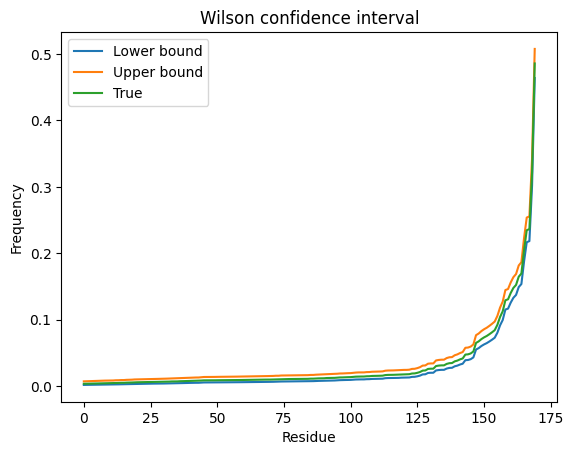

In [37]:
def plot_confidence_interval_wilson(observed_freq, lower_bound, upper_bound):
    ord = np.argsort(observed_freq)
    observed_freq = observed_freq[ord]
    lower_bound = lower_bound[ord]
    upper_bound = upper_bound[ord]
    plt.plot(lower_bound, label='Lower bound')
    plt.plot(upper_bound, label='Upper bound')
    plt.plot(observed_freq, label='True')
    plt.legend()
    plt.xlabel('Residue')
    plt.ylabel('Frequency')
    plt.title('Wilson confidence interval')
    
plot_confidence_interval_wilson(observed_freq, *wilson(observed_freq, size_sample))

## Clopper-Pearson 
### Define function

In [38]:
def clopper_pearson(*args):
    return sm.stats.proportion_confint(*args, method='beta')

### Predict confidence intervals with Clopper-Pearson 

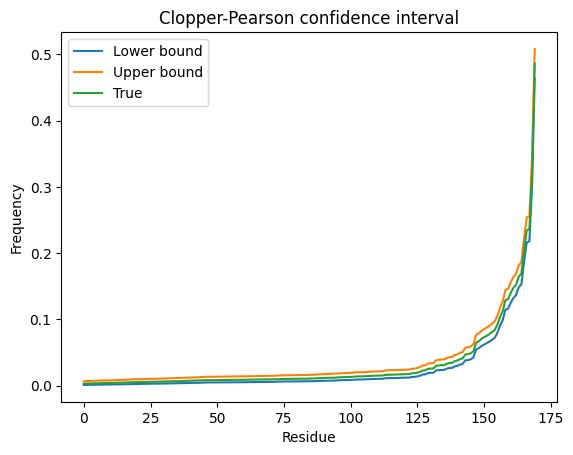

In [39]:
def plot_clopper_pearson(observed_freq, lower_bound, upper_bound):
    ord = np.argsort(observed_freq)
    observed_freq = observed_freq[ord]
    lower_bound = lower_bound[ord]
    upper_bound = upper_bound[ord]
    plt.plot(lower_bound, label='Lower bound')
    plt.plot(upper_bound, label='Upper bound')
    plt.plot(observed_freq, label='True')
    plt.legend()
    plt.xlabel('Residue')
    plt.ylabel('Frequency')
    plt.title('Clopper-Pearson confidence interval')
    
plot_clopper_pearson(observed_freq, *clopper_pearson(observed_freq*size_sample, size_sample))

## Agresti-Coull
### Define function

In [40]:
def agresti_coull(*args):
    return sm.stats.proportion_confint(*args, method='agresti_coull')

### Predict confidence intervals with Agresti-Coull

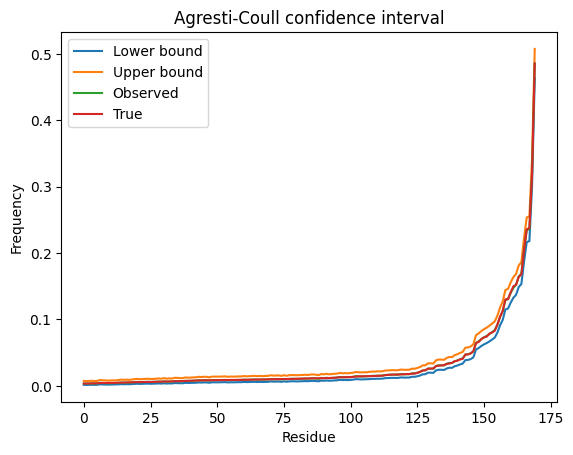

In [41]:
def plot_agresti_coull(observed_freq, data, lower_bound, upper_bound):
    true_mutation_rate = data.sum(axis=0)/data.shape[0]
    ord = np.argsort(true_mutation_rate)
    true_mutation_rate = true_mutation_rate[ord]
    observed_freq = observed_freq[ord]
    lower_bound = lower_bound[ord]
    upper_bound = upper_bound[ord]
    plt.plot(lower_bound, label='Lower bound')
    plt.plot(upper_bound, label='Upper bound')
    plt.plot(observed_freq, label='Observed')
    plt.plot(true_mutation_rate, label='True')
    plt.legend()
    plt.xlabel('Residue')
    plt.ylabel('Frequency')
    plt.title('Agresti-Coull confidence interval')
    
plot_agresti_coull(observed_freq, data, *agresti_coull(observed_freq*size_sample, size_sample))

## Poisson

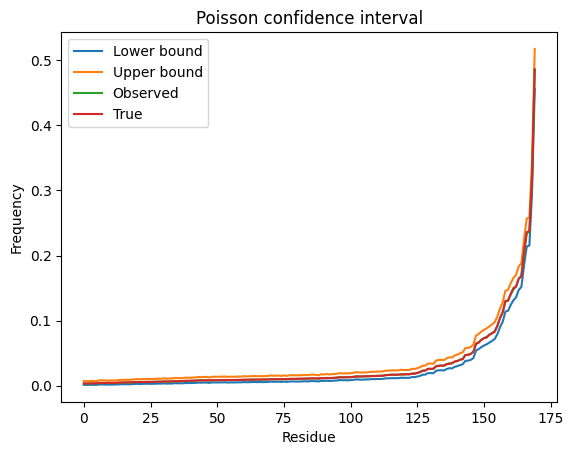

In [42]:
import scipy

def predict_confidence_interval_poisson(observed_freq, size_sample, alpha=0.05):
    cov = size_sample
    mut = observed_freq*size_sample
    return 0.5*scipy.stats.chi2.ppf(alpha/2, df=2*mut)/cov, 0.5*scipy.stats.chi2.ppf(1-alpha/2, df=2*(mut+1))/cov

def plot_poisson(observed_freq, data, lower_bound, upper_bound):
    true_mutation_rate = data.sum(axis=0)/data.shape[0]
    ord = np.argsort(true_mutation_rate)
    true_mutation_rate = true_mutation_rate[ord]
    observed_freq = observed_freq[ord]
    lower_bound = lower_bound[ord]
    upper_bound = upper_bound[ord]
    plt.plot(lower_bound, label='Lower bound')
    plt.plot(upper_bound, label='Upper bound')
    plt.plot(observed_freq, label='Observed')
    plt.plot(true_mutation_rate, label='True')
    plt.legend()
    plt.xlabel('Residue')
    plt.ylabel('Frequency')
    plt.title('Poisson confidence interval')

plot_poisson(observed_freq, data, *predict_confidence_interval_poisson(observed_freq, size_sample))

## Perfomance assessment confidence intervals

In [54]:

n_trials_per_dataset = 10
bootstrap_iterations = 10000
n_datasets = 10
methods = ['bootstrap', 'binomial', 'wilson', 'clopper_pearson', 'agresti_coull', 'poisson']

for size_sample in [500, 1000, 2000, 3000, 5000, 10000]:
    failures = {m:[] for m in methods}
    size_ci = {m:[] for m in methods}

    for f in os.listdir('../../bv'):
        
        # read dataset
        data = process_data(pd.read_orc('../../bv/' + f))
        true_mutation_rate = data.sum(axis=0)/data.shape[0]

        fail = {m:[] for m in methods}
        size = {m:[] for m in methods}
        for _ in range(n_trials_per_dataset):
            
            # generate a new sample
            sample = data[np.random.randint(0, data.shape[0], size=size_sample)]
            observed_freq = sample.sum(axis=0)/size_sample
            
            # count failures bootstrap
            lb_bs, ub_bs = predict_confidence_interval_bootstrap(sample, bootstrap_iterations=bootstrap_iterations)
            fail['bootstrap'].append(100*np.logical_or(ub_bs < true_mutation_rate, lb_bs > true_mutation_rate).sum()/data.shape[1])
            size['bootstrap'].append(np.mean(ub_bs - lb_bs))
            
            # count failures binomial
            lb_bin, ub_bin = predict_confidence_interval_binomial_distribution(observed_freq, size_sample)
            fail['binomial'].append(100*np.logical_or(ub_bs < true_mutation_rate, lb_bs > true_mutation_rate).sum()/data.shape[1])
            size['binomial'].append(np.mean(ub_bin - lb_bin))
            
            # count Wilson failures
            lb_wilson, ub_wilson = wilson(observed_freq, size_sample)
            fail['wilson'].append(100*np.logical_or(ub_wilson < true_mutation_rate, lb_wilson > true_mutation_rate).sum()/data.shape[1])
            size['wilson'].append(np.mean(ub_wilson - lb_wilson))
            
            # count Clopper-Pearson failures
            lb_cp, ub_cp = clopper_pearson(observed_freq*size_sample, size_sample)
            fail['clopper_pearson'].append(100*np.logical_or(ub_cp < true_mutation_rate, lb_cp > true_mutation_rate).sum()/data.shape[1])
            size['clopper_pearson'].append(np.mean(ub_cp - lb_cp))
            
            # count Agresti-Coull failures
            lb_ac, ub_ac = agresti_coull(observed_freq*size_sample, size_sample)
            fail['agresti_coull'].append(100*np.logical_or(ub_ac < true_mutation_rate, lb_ac > true_mutation_rate).sum()/data.shape[1])
            size['agresti_coull'].append(np.mean(ub_ac - lb_ac))
            
            # count Poisson failures
            lb_poisson, ub_poisson = predict_confidence_interval_poisson(observed_freq, size_sample)
            fail['poisson'].append(100*np.logical_or(ub_poisson < true_mutation_rate, lb_poisson > true_mutation_rate).sum()/data.shape[1])
            size['poisson'].append(np.mean(ub_poisson - lb_poisson))

        for m in methods:
            failures[m].append(fail[m])
            size_ci[m].append(size[m])
        #    print(f'{n_dataset}: {m}: {np.mean(failures[m][-1])}% failure rate')
        #print('----------------------------------------------------------')
        
    df = pd.DataFrame(
        {
            'Bootstrap': np.array(failures['bootstrap']).flatten(), 
            'Binomial': np.array(failures['binomial']).flatten(), 
            'Wilson': np.array(failures['wilson']).flatten(), 
            'Clopper-Pearson': np.array(failures['clopper_pearson']).flatten(), 
            'Agresti-Coull': np.array(failures['agresti_coull']).flatten(), 
            'Poisson': np.array(failures['poisson']).flatten(), 
            'Trial' : np.repeat(np.arange(n_trials_per_dataset), len(os.listdir('../../bv')))
        })
    df = pd.melt(df, id_vars=['Trial'], value_vars=[c for c in df.columns if not c == 'Trial'], var_name='Method', value_name='Failure rate (%)')

    fig = px.box(df, x='Trial', y='Failure rate (%)', color='Method', title='Failure rate of the confidence interval methods. N = {}'.format(size_sample))
    fig.show()
    
    df = pd.DataFrame(
        {
            'Bootstrap': np.array(size_ci['bootstrap']).flatten(), 
            'Binomial': np.array(size_ci['binomial']).flatten(), 
            'Wilson': np.array(size_ci['wilson']).flatten(), 
            'Clopper-Pearson': np.array(size_ci['clopper_pearson']).flatten(), 
            'Agresti-Coull': np.array(size_ci['agresti_coull']).flatten(), 
            'Poisson': np.array(size_ci['poisson']).flatten(), 
            'Trial' : np.repeat(np.arange(n_trials_per_dataset), len(os.listdir('../../bv')))
        })
    df = pd.melt(df, id_vars=['Trial'], value_vars=[c for c in df.columns if not c == 'Trial'], var_name='Method', value_name='Size of the CI')
    
    fig = px.box(df, x='Trial', y='Size of the CI', color='Method', title='Size of the confidence interval methods. N = {}'.format(size_sample))
    fig.show()
    

## Conclusion

The alternative methods are more reliable than the bootstrap method.

##